In [9]:
# import packages
import geopandas as gpd
import os
from requests import get
from urllib.parse import urlparse
import pandas as pd

In [10]:
def cache_data(src:str, dest:str) -> str:
    """
    Downloads a file from the given URL `src` and saves it to the `dest` directory.
    If the file already exists and is of sufficient size, skips the download.
    
    Args:
        src (str): The source URL of the file to be downloaded.
        dest (str): The destination directory where the file will be saved.
        
    Returns:
        str: The full path to the downloaded (or existing) file.
    """    
    url = urlparse(src) # We assume that this is some kind of valid URL 
    fn  = os.path.split(url.path)[-1] # Extract the filename
    dfn = os.path.join(dest,fn) # Destination filename
    
    if not os.path.isfile(dfn) or os.path.getsize(dfn) < 250:
        
        print(f"{dfn} not found, downloading!")

        path = os.path.split(dest)
        
        if len(path) >= 1 and path[0] != '':
            os.makedirs(os.path.join(*path), exist_ok=True)
            
        with open(dfn, "wb") as file:
            response = get(src)
            file.write(response.content)
            
        print("\tDone downloading...")

    else:
        print(f"Found {dfn} locally!")

    return dfn

In [11]:
# listing data,choose the data of 2024
ymd  = '20240614'
city = 'London'
host = 'https://orca.casa.ucl.ac.uk'
list_url  = f'{host}/~jreades/data/{ymd}-{city}-listings.parquet'
transport_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Transport_Classification_of_Londoners_(TCoL)/Transport_Classification_of_Londoners_(TCoL).shp'
inequity_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Borough_pages_data_UPDATE_9_2024_HACTAR(1).csv'
pop_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/population%20by%20borough.xlsx'
sta_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/London%20stations/London%20stations.shp'
line_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/London%20Train%20Lines/London%20Train%20Lines.shp'
borough_url = 'https://github.com/Chocolateyz/Chocolate/raw/refs/heads/main/Boroughs.gpkg'

In [12]:
# the data frame of datas
listing_df = pd.read_parquet(cache_data(list_url, os.path.join('data','raw')))
# inequity data
inequity = pd.read_csv(cache_data(inequity_url, os.path.join('data','raw')),skiprows=11, header=0)
# population data
pop = pd.read_excel(cache_data(pop_url, os.path.join('data','raw')))
# borough outline
borough = gpd.read_file(cache_data(borough_url, os.path.join('data','raw')))

# station point data
station = gpd.read_file(sta_url)
# train line data
line = gpd.read_file(line_url)
# transport data, spatial unit is OA(output area)
transport = gpd.read_file(transport_url)

Found data/raw/20240614-London-listings.parquet locally!
Found data/raw/Borough_pages_data_UPDATE_9_2024_HACTAR(1).csv locally!
Found data/raw/population%20by%20borough.xlsx locally!
Found data/raw/Boroughs.gpkg locally!


In [13]:
# this is the columns list, if you want to focus on a certain topic, choose some of them
# listing data
columns_list = listing_df.columns.to_list()
print(f'listing data columns: {columns_list}')
print(f"Data frame is {listing_df.shape[0]:,} x {listing_df.shape[1]}")
# transport data
columns_transport = transport.columns.to_list()
print(f'transport data columns: {columns_transport}')
# inequity data
columns_inequity = inequity.columns.to_list()
print(f'inequity data columns: {columns_inequity}')
# population data
columns_pop = pop.columns.to_list()
print(f'population data columns: {columns_pop}')
# station data
columns_station = station.columns.to_list()
print(f'station data columns: {columns_station}')
# line data
columns_line = line.columns.to_list()
print(f'line data columns: {columns_line}')
# borough outline
columns_borough = borough.columns.to_list()
print(f'borough data columns: {columns_borough}')

listing data columns: ['id', 'listing_url', 'last_scraped', 'name', 'description', 'host_id', 'host_name', 'host_since', 'host_location', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count', 'host_verifications', 'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews', 'first_review', 'last_review', 'review_scores_rating', 'reviews_per_month']
Data frame is 85,127 x 31
transport data columns: ['OBJECTID', 'TCOL_SEGME', 'TCOL_SEG_1', 'OA_POPULAT', 'SEGMENT_PO', 'LOAC_SUPER', 'LOAC_GROUP', 'LOAC_SUB_G', 'LOCAL_AUTH', 'PROPENSITY', 'PROPENSI_1', 'PROPENSI_2', 'PROPENSI_3', 'CAR_DRIVER', 'CAR_PASSEN', 'BUS_TRIPS_', 'TRAIN_TRIP', 'RIVER_TRIP', 'TRAM_TRIPS', 'TUBE_TRIPS', 'BICYCLE_TR', 'HIRE_BIKE_', 'DLR_TRIPS_', 'POWERED_TW', 'TAXI_PHV_T', 'WALK_TRIPS', 'CAR_AVAILA', 'AVERAGE_IN', 'STUDENT', 'NO_CHILDRE', 'NO_CHILD_1', 'NO

In [1]:
# listing_df.head()

In [14]:
# what can be needed in listing
airbnb_cols = [
    'id', 'host_since', 'host_is_superhost', 'host_listings_count', 'host_total_listings_count',
    'latitude', 'longitude', 'property_type', 'room_type', 'accommodates', 'price',
    'minimum_nights', 'maximum_nights', 'availability_365', 'number_of_reviews'
]

airbnb_df = listing_df[airbnb_cols].copy()


In [15]:
# price all NaN to '0' then str
airbnb_df['price'] = airbnb_df['price'].fillna('0').astype(str)
# price float
airbnb_df['price'] = airbnb_df['price'].str.replace('£', '').str.replace(',', '').astype(float)

# host since date
airbnb_df['host_since'] = pd.to_datetime(airbnb_df['host_since'], errors='coerce')

# superhost
airbnb_df['host_is_superhost'] = listing_df['host_is_superhost']

# delete NaN
airbnb_df.dropna(subset=['price', 'latitude', 'longitude', 'host_since'], inplace=True)

# NaN to 0
airbnb_df.loc[:, 'host_listings_count'] = airbnb_df['host_listings_count'].fillna(0)
airbnb_df.loc[:, 'host_total_listings_count'] = airbnb_df['host_total_listings_count'].fillna(0)
airbnb_df.loc[:, 'number_of_reviews'] = airbnb_df['number_of_reviews'].fillna(0)

print(airbnb_df.isnull().sum())


id                           0
host_since                   0
host_is_superhost            0
host_listings_count          0
host_total_listings_count    0
latitude                     0
longitude                    0
property_type                0
room_type                    0
accommodates                 0
price                        0
minimum_nights               0
maximum_nights               0
availability_365             0
number_of_reviews            0
dtype: int64


In [16]:
print(airbnb_df.describe())

                 id                     host_since  host_listings_count  \
count  8.512700e+04                          85127         85127.000000   
mean   3.576011e+17  2017-01-30 15:42:02.795352832            49.239466   
min    1.391300e+04            2008-12-03 00:00:00             1.000000   
25%    2.201646e+07            2014-09-24 00:00:00             1.000000   
50%    4.943680e+07            2016-06-13 00:00:00             2.000000   
75%    8.130157e+17            2019-04-26 00:00:00             7.000000   
max    9.738958e+17            2023-09-04 00:00:00          3023.000000   
std    4.111131e+17                            NaN           294.724362   

       host_total_listings_count      latitude     longitude  accommodates  \
count               85127.000000  85127.000000  85127.000000  85127.000000   
mean                   86.721874     51.509428     -0.128178      3.201475   
min                     1.000000     51.295937     -0.497800      1.000000   
25%         

In [17]:
# Superhost Ratio
superhost_ratio = airbnb_df['host_is_superhost'].value_counts(normalize=True)
print("Superhost Ratio:\n", superhost_ratio)

Superhost Ratio:
 host_is_superhost
False    0.834248
True     0.165752
Name: proportion, dtype: float64


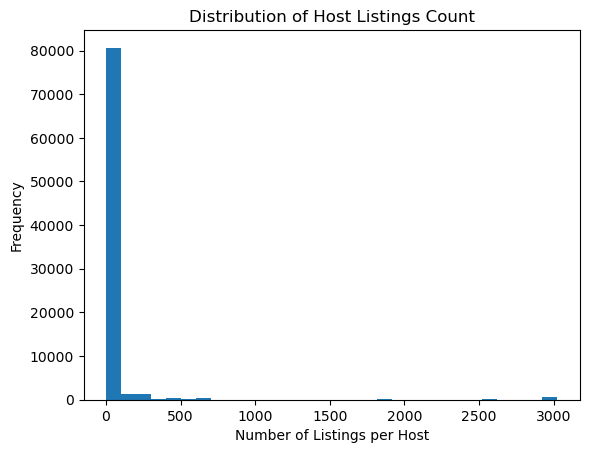

In [18]:
import matplotlib.pyplot as plt
# Listings per Host
airbnb_df['host_listings_count'].plot(kind='hist', bins=30, title='Distribution of Host Listings Count')
plt.xlabel('Number of Listings per Host')
plt.ylabel('Frequency')
plt.show()

property_type
Entire rental unit             33450
Private room in rental unit    13278
Private room in home            9795
Entire condo                    8656
Entire home                     7530
                               ...  
Island                             1
Earthen home                       1
Dome                               1
Castle                             1
Yurt                               1
Name: count, Length: 99, dtype: int64
room_type
Entire home/apt    54203
Private room       30366
Shared room          340
Hotel room           218
Name: count, dtype: int64


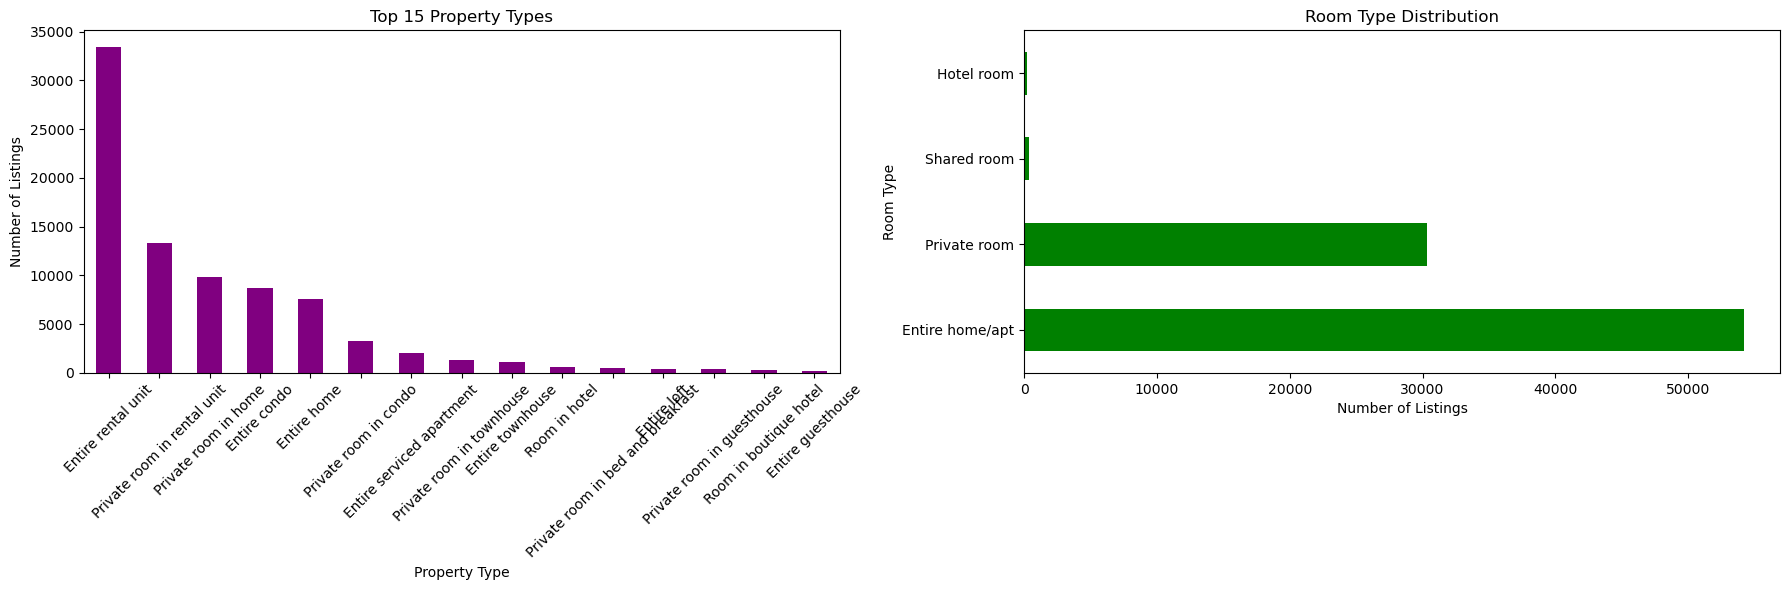

In [19]:
# property type counts
property_counts = airbnb_df['property_type'].value_counts()
print(property_counts)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# visualize first 15s
airbnb_df['property_type'].value_counts().head(15).plot(kind='bar', ax=axes[0], color='purple')
axes[0].set_title('Top 15 Property Types')
axes[0].set_xlabel('Property Type')
axes[0].set_ylabel('Number of Listings')
axes[0].tick_params(axis='x', rotation=45)

# room type
room_type_counts = airbnb_df['room_type'].value_counts()
print(room_type_counts)
airbnb_df['room_type'].value_counts().plot(kind='barh', ax=axes[1], color='green')
axes[1].set_title('Room Type Distribution')
axes[1].set_xlabel('Number of Listings')
axes[1].set_ylabel('Room Type')

plt.tight_layout()
plt.show()

Minimum Nights Stats:
 count    85127.000000
mean         5.492946
std         22.872656
min          1.000000
25%          1.000000
50%          2.000000
75%          4.000000
max       1125.000000
Name: minimum_nights, dtype: float64
Maximum Nights Stats:
 count    8.512700e+04
mean     6.919066e+03
std      1.799485e+06
min      1.000000e+00
25%      6.000000e+01
50%      3.650000e+02
75%      1.125000e+03
max      5.248556e+08
Name: maximum_nights, dtype: float64


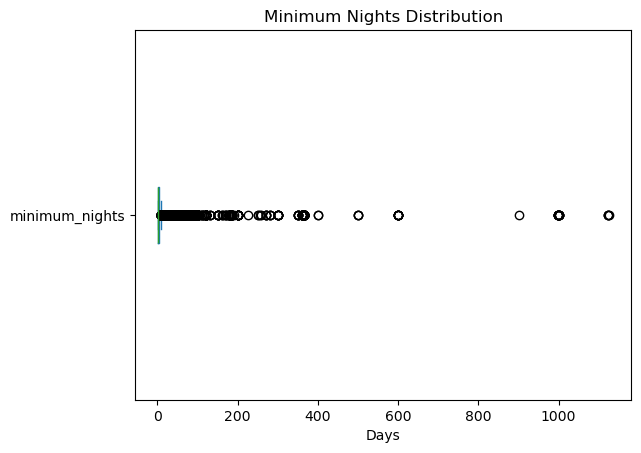

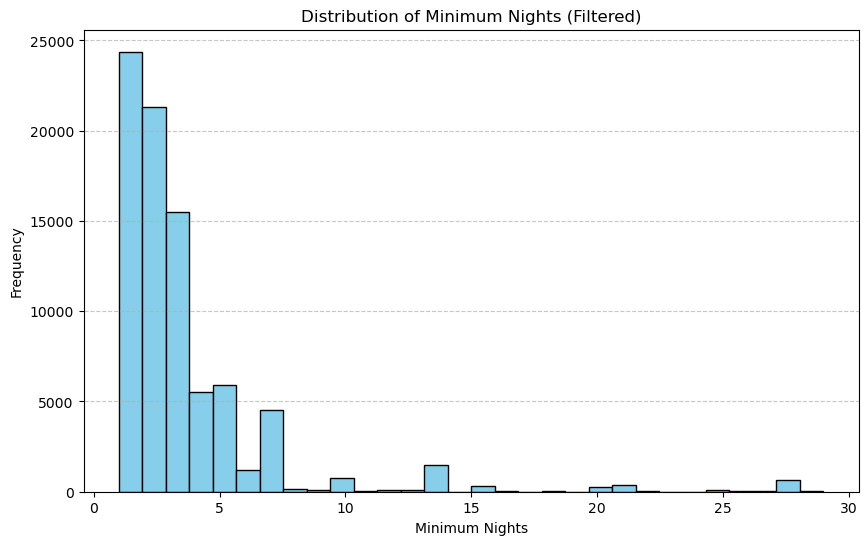

In [21]:
# Minimum & Maximum Nights
print("Minimum Nights Stats:\n", airbnb_df['minimum_nights'].describe())
print("Maximum Nights Stats:\n", airbnb_df['maximum_nights'].describe())
# box plot
airbnb_df['minimum_nights'].plot(kind='box', vert=False, title='Minimum Nights Distribution')
plt.xlabel('Days')
plt.show()
# add <30 days
filtered_min_nights = airbnb_df[airbnb_df['minimum_nights'] < 30]
plt.figure(figsize=(10, 6))
filtered_min_nights['minimum_nights'].plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Minimum Nights (Filtered)')
plt.xlabel('Minimum Nights')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Price Stats:
 count    85127.000000
mean       183.626347
std        490.301996
min          0.000000
25%         65.000000
50%        112.000000
75%        196.000000
max      80100.000000
Name: price, dtype: float64


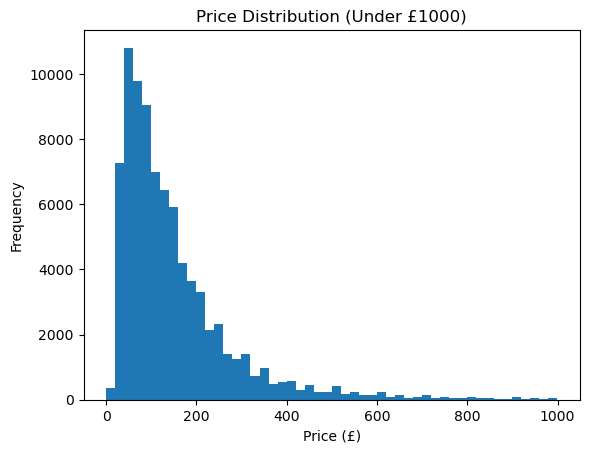

In [14]:
# Price
print("Price Stats:\n", airbnb_df['price'].describe())
# Under 500
airbnb_df[airbnb_df['price'] < 1000]['price'].plot(kind='hist', bins=50, title='Price Distribution (Under £1000)')
plt.xlabel('Price (£)')
plt.show()

<Figure size 1200x1000 with 0 Axes>

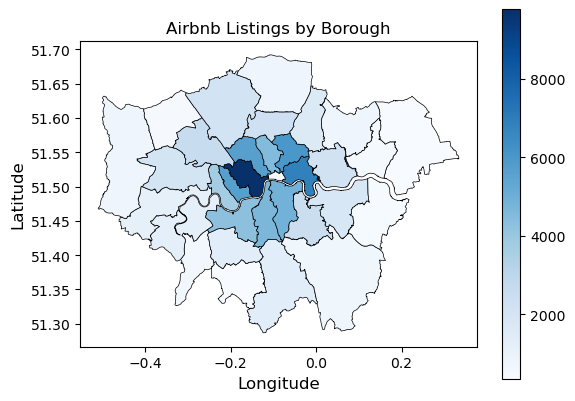

In [36]:
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Airbnb GeoDataFrame
geometry = gpd.points_from_xy(airbnb_df['longitude'], airbnb_df['latitude'])
airbnb_gdf = gpd.GeoDataFrame(airbnb_df, geometry=geometry, crs="EPSG:4326")

borough = borough.to_crs(epsg=4326)
airbnb_gdf = airbnb_gdf.to_crs(epsg=4326)

# Spatialjoin
airbnb_in_borough = gpd.sjoin(airbnb_gdf, borough_inequity, how='inner', predicate='within')
borough_stats = airbnb_in_borough.groupby('NAME').agg(total_listings=('id', 'count')).reset_index()
borough_final = borough_inequity.merge(borough_stats, on='NAME', how='left')

plt.figure(figsize=(12, 10))
borough_final.plot(column='total_listings', cmap='Blues', legend=True, linewidth=0.5, edgecolor='black')
plt.title('Airbnb Listings by Borough')
plt.xlabel("Longitude", fontsize=12)
plt.ylabel("Latitude", fontsize=12)
plt.show()